# Applied-Data-Science-Capstone

## Peer-graded Assignment: Capstone Project - The Battle of Neighborhoods

Now that you have been equipped with the skills and the tools to use location data to explore a geographical location, 
over the course of two weeks, you will have the opportunity to be as creative as you want and come up with an idea to 
leverage the Foursquare location data to explore or compare neighborhoods or cities of your choice or to come up with a 
problem that you can use the Foursquare location data to solve.

## 1) Introduction/Business Problem

Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to 
solve or execute. Remember that data science problems always target an audience and are meant to help a group of 
stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about 
your problem.

**_The purpose of this project to assist persons looking to open a new Caribbean restaurant in New York City to choose the right location.
This would be done by providing data about the income and population of each neighbourhood as well as the competitors already present in 
the same regions._**

**_Questions that can be asked using the above mentioned datasets_**

-What is best location in New York City for Caribbean Cuisine ?

-Which areas have potential Caribbean Resturant Market ?

-Which all areas lack Caribbean Resturants ?

## 2) Data

Describe the data that you will be using to solve the problem or execute your idea. Remember that you will need to use 
the Foursquare location data to solve the problem or execute your idea. You can absolutely use other datasets in 
combination with the Foursquare location data. So make sure that you provide adequate explanation and discussion, 
with examples, of the data that you will be using, even if it is only Foursquare location data.

**_For this project we need the following data :_**

**_New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude._**

Data source : https://cocl.us/new_york_dataset

_Description : This data set contains the required information. And we will use this data set to explore various neighborhoods of new york city._

**_Caribbean resturants in each neighborhood of new york city._**

Data source : Fousquare API

_Description : By using this api we will get all the venues in each neighborhood. We can filter these venues to get only caribbean resturants._

**_GeoSpace data_**

Data source : https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm

_Description : By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map._

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [2]:
#function to get the geocodes i.e latitude and longitude of a given location using geopy.
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [13]:
#function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given latitude and longitude
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'AJD2V44P2WUEHA5EJNYN5NEARTK44AF4W4VXH10H04J4SAQP' # your Foursquare ID
    CLIENT_SECRET = '2CO153Y5FM2BTBD1LAQHLRVGZXARUWOO1NAPXLA5JYPUHVYY' # your Foursquare Secret
    VERSION = '20191223' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [14]:
# function to get venue details like like count , rating , tip counts for a given venue id. This will be used for ranking.
def get_venue_details(venue_id):
        
    CLIENT_ID = 'AJD2V44P2WUEHA5EJNYN5NEARTK44AF4W4VXH10H04J4SAQP' # your Foursquare ID
    CLIENT_SECRET = '2CO153Y5FM2BTBD1LAQHLRVGZXARUWOO1NAPXLA5JYPUHVYY' # your Foursquare Secret
    VERSION = '20191223' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
#funtion to get the new york city data such as Boroughs, Neighborhoods along with their latitude and longitude.
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [7]:
new_york_data=get_new_york_data()
new_york_data.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

In [8]:
new_york_data.shape

(306, 4)

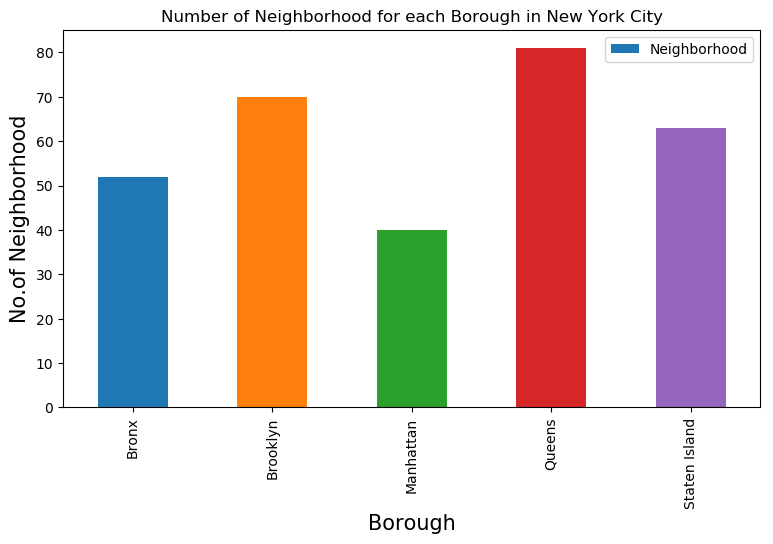

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From this barchart we see Queens has has the highest number of Neighborhoods.

Now we will get Caribbean resturants for each Neighborhood

In [15]:
# prepare neighborhood list that contains caribbean resturants
column_names=['Borough', 'Neighborhood', 'ID','Name']
caribbean_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    caribbean_resturants=venues[venues['Category']=='Caribbean Restaurant']   
    print('(',count,'/',len(new_york_data),')','caribbean Resturants in '+Neighborhood+', '+Borough+':'+str(len(caribbean_resturants)))
    for resturant_detail in caribbean_resturants.values.tolist():
        id, name , category=resturant_detail
        caribbean_rest_ny = caribbean_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) caribbean Resturants in Wakefield, Bronx:4
( 2 / 306 ) caribbean Resturants in Co-op City, Bronx:2
( 3 / 306 ) caribbean Resturants in Eastchester, Bronx:5
( 4 / 306 ) caribbean Resturants in Fieldston, Bronx:0
( 5 / 306 ) caribbean Resturants in Riverdale, Bronx:0
( 6 / 306 ) caribbean Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) caribbean Resturants in Marble Hill, Manhattan:1
( 8 / 306 ) caribbean Resturants in Woodlawn, Bronx:1
( 9 / 306 ) caribbean Resturants in Norwood, Bronx:2
( 10 / 306 ) caribbean Resturants in Williamsbridge, Bronx:7
( 11 / 306 ) caribbean Resturants in Baychester, Bronx:1
( 12 / 306 ) caribbean Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) caribbean Resturants in City Island, Bronx:0
( 14 / 306 ) caribbean Resturants in Bedford Park, Bronx:1
( 15 / 306 ) caribbean Resturants in University Heights, Bronx:0
( 16 / 306 ) caribbean Resturants in Morris Heights, Bronx:0
( 17 / 306 ) caribbean Resturants in Fordham, Bronx:1
( 18 / 306 ) caribbea

( 136 / 306 ) caribbean Resturants in Forest Hills, Queens:1
( 137 / 306 ) caribbean Resturants in Kew Gardens, Queens:1
( 138 / 306 ) caribbean Resturants in Richmond Hill, Queens:2
( 139 / 306 ) caribbean Resturants in Flushing, Queens:0
( 140 / 306 ) caribbean Resturants in Long Island City, Queens:0
( 141 / 306 ) caribbean Resturants in Sunnyside, Queens:1
( 142 / 306 ) caribbean Resturants in East Elmhurst, Queens:0
( 143 / 306 ) caribbean Resturants in Maspeth, Queens:0
( 144 / 306 ) caribbean Resturants in Ridgewood, Queens:0
( 145 / 306 ) caribbean Resturants in Glendale, Queens:0
( 146 / 306 ) caribbean Resturants in Rego Park, Queens:0
( 147 / 306 ) caribbean Resturants in Woodhaven, Queens:0
( 148 / 306 ) caribbean Resturants in Ozone Park, Queens:1
( 149 / 306 ) caribbean Resturants in South Ozone Park, Queens:2
( 150 / 306 ) caribbean Resturants in College Point, Queens:1
( 151 / 306 ) caribbean Resturants in Whitestone, Queens:0
( 152 / 306 ) caribbean Resturants in Baysi

( 267 / 306 ) caribbean Resturants in Astoria Heights, Queens:0
( 268 / 306 ) caribbean Resturants in Claremont Village, Bronx:1
( 269 / 306 ) caribbean Resturants in Concourse Village, Bronx:3
( 270 / 306 ) caribbean Resturants in Mount Eden, Bronx:0
( 271 / 306 ) caribbean Resturants in Mount Hope, Bronx:0
( 272 / 306 ) caribbean Resturants in Sutton Place, Manhattan:0
( 273 / 306 ) caribbean Resturants in Hunters Point, Queens:0
( 274 / 306 ) caribbean Resturants in Turtle Bay, Manhattan:0
( 275 / 306 ) caribbean Resturants in Tudor City, Manhattan:0
( 276 / 306 ) caribbean Resturants in Stuyvesant Town, Manhattan:0
( 277 / 306 ) caribbean Resturants in Flatiron, Manhattan:0
( 278 / 306 ) caribbean Resturants in Sunnyside Gardens, Queens:0
( 279 / 306 ) caribbean Resturants in Blissville, Queens:1
( 280 / 306 ) caribbean Resturants in Fulton Ferry, Brooklyn:0
( 281 / 306 ) caribbean Resturants in Vinegar Hill, Brooklyn:0
( 282 / 306 ) caribbean Resturants in Weeksville, Brooklyn:5
(

In [16]:
caribbean_rest_ny.head()

Borough Neighborhood                        ID  \
0   Bronx    Wakefield  4d375ce799fe8eec99fd2355   
1   Bronx    Wakefield  4c9e50e38afca09379b2ff15   
2   Bronx    Wakefield  4c10f6aece57c92804a682d2   
3   Bronx    Wakefield  4bf5c0a294b2a5937c42acee   
4   Bronx   Co-op City  4baab2b0f964a520c7803ae3   

                                Name  
0                 Ripe Kitchen & Bar  
1                    Ali's Roti Shop  
2        Jackie's West Indian Bakery  
3  Golden Krust Caribbean Restaurant  
4              Country Thyme Cuisine

In [17]:
caribbean_rest_ny.shape

(247, 4)

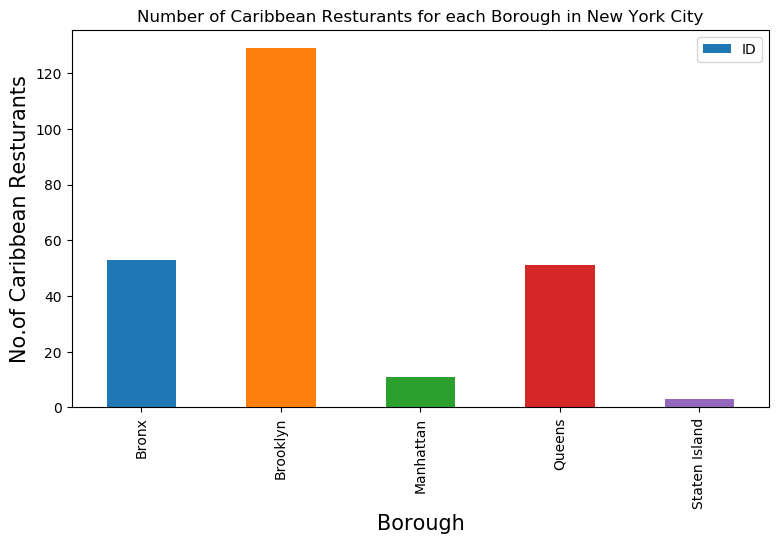

In [18]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Caribbean Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Caribbean Resturants', fontsize=15)
#giving a bar plot
caribbean_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

From the barchart we see Brooklyn has the highest number.

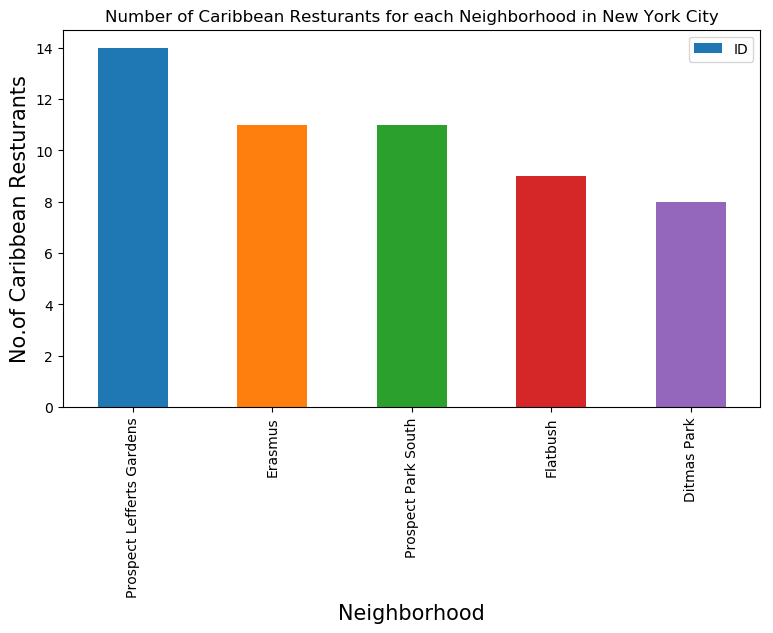

In [19]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Caribbean Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Caribbean Resturants', fontsize=15)
#giving a bar plot
caribbean_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [20]:
caribbean_rest_ny[caribbean_rest_ny['Neighborhood']=='Prospect Lefferts Gardens']

Borough               Neighborhood                        ID  \
93   Brooklyn  Prospect Lefferts Gardens  4a6cba95f964a52073d11fe3   
94   Brooklyn  Prospect Lefferts Gardens  4d0e9e455b8a8cfa5e50eb83   
95   Brooklyn  Prospect Lefferts Gardens  4bdcade72a3a0f470fecb3b6   
96   Brooklyn  Prospect Lefferts Gardens  54fbad6b498e83b622d3c796   
97   Brooklyn  Prospect Lefferts Gardens  4c79b5f683a7bfb7527f7ff8   
98   Brooklyn  Prospect Lefferts Gardens  4e0904426284d9ee92de668b   
99   Brooklyn  Prospect Lefferts Gardens  4b085b46f964a520f50923e3   
100  Brooklyn  Prospect Lefferts Gardens  4bd3475c046076b084a97571   
101  Brooklyn  Prospect Lefferts Gardens  4e26eebed16486291ba4d622   
102  Brooklyn  Prospect Lefferts Gardens  4cd4918576ab721eacf3676a   
103  Brooklyn  Prospect Lefferts Gardens  4c5dd01cd25320a1a924c77a   
104  Brooklyn  Prospect Lefferts Gardens  4a611b29f964a520dec11fe3   
105  Brooklyn  Prospect Lefferts Gardens  4e21d5c6e4cdf68591898a5e   
106  Brooklyn  Prospect Lefferts Gardens  5a0f90888264443d4b674cdf   

                                      Name  
93                    Peppa's Jerk Chicken  
94                    De Hot Pot Roti Shop  
95                    MangoSeed Restaurant  
96                         The Food Sermon  
97                Errol's Caribbean Bakery  
98       Golden Krust Caribbean Restaurant  
99                                Gloria's  
100                            Culpepper's  
101                        Jen's Roti Shop  
102                      Soldiers Jamaican  
103  De Bamboo Express Restaurant & Bakery  
104               Nio's Trinidad Roti Shop  
105                        Caribbean Vibes  
106                       Caribbean Social

With a total of 14 Cribbean Resturants, Prospect Lefferts Gardens in Brooklyn takes the top spot

Time to get the rankings of each resturant.

In [21]:
# prepare neighborhood list that contains caribbean resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
caribbean_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in caribbean_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(caribbean_rest_ny),')','processed')
    caribbean_rest_stats_ny = caribbean_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                Name  Likes  Rating  Tips
0  4d375ce799fe8eec99fd2355  Ripe Kitchen & Bar     70     8.8    33
( 1 / 247 ) processed
                         ID             Name  Likes  Rating  Tips
0  4c9e50e38afca09379b2ff15  Ali's Roti Shop     16     8.7     9
( 2 / 247 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c10f6aece57c92804a682d2  Jackie's West Indian Bakery     22     7.7    13
( 3 / 247 ) processed
                         ID                               Name  Likes  Rating  \
0  4bf5c0a294b2a5937c42acee  Golden Krust Caribbean Restaurant      2     6.7   

   Tips  
0     1  
( 4 / 247 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4baab2b0f964a520c7803ae3  Country Thyme Cuisine     18     8.4     7
( 5 / 247 ) processed
                         ID                               Name  Likes  Rating  \
0  4c757642b474a1cd2858b9bf  Golden Krust Caribbean Rest

                         ID           Name  Likes  Rating  Tips
0  54fa4b21498e671122cb4d11  Island Burger     27     8.4     8
( 48 / 247 ) processed
                         ID              Name  Likes  Rating  Tips
0  4be5ad3a2457a5932fd0ab15  Fisherman's Cove     74     8.5    18
( 49 / 247 ) processed
                         ID        Name  Likes  Rating  Tips
0  5879815625911e1bb23364a0  Sip unWINE      8     7.4     3
( 50 / 247 ) processed
                         ID           Name  Likes  Rating  Tips
0  4ce6e9808ef78cfaf09b8f9b  Faye & King's     13     7.4     6
( 51 / 247 ) processed
                         ID           Name  Likes  Rating  Tips
0  4ce0265e78ddf04df9b3a498  Bake & Things     50     7.7    14
( 52 / 247 ) processed
                         ID                                   Name  Likes  \
0  4bf6df9d4a67c928b49422cf  Golden Krust Caribbean Bakery & Grill      7   

   Rating  Tips  
0     6.5     1  
( 53 / 247 ) processed
                         ID    

                         ID                  Name  Likes  Rating  Tips
0  4bdcade72a3a0f470fecb3b6  MangoSeed Restaurant    177     8.7    77
( 96 / 247 ) processed
                         ID             Name  Likes  Rating  Tips
0  54fbad6b498e83b622d3c796  The Food Sermon    164     9.2    38
( 97 / 247 ) processed
                         ID                      Name  Likes  Rating  Tips
0  4c79b5f683a7bfb7527f7ff8  Errol's Caribbean Bakery     11     8.0     5
( 98 / 247 ) processed
                         ID                               Name  Likes  Rating  \
0  4e0904426284d9ee92de668b  Golden Krust Caribbean Restaurant     12     7.8   

   Tips  
0     8  
( 99 / 247 ) processed
                         ID      Name  Likes  Rating  Tips
0  4b085b46f964a520f50923e3  Gloria's     30     8.5    12
( 100 / 247 ) processed
                         ID         Name  Likes  Rating  Tips
0  4bd3475c046076b084a97571  Culpepper's     20     7.2    13
( 101 / 247 ) processed
           

                         ID               Name  Likes  Rating  Tips
0  5130c73e72da35b105337efe  Anita's Roti Shop      7     6.8     0
( 145 / 247 ) processed
                         ID            Name  Likes  Rating  Tips
0  4ca8f719d971b1f77e0b1ae1  The Smokehouse     63     8.1    26
( 146 / 247 ) processed
                         ID              Name  Likes  Rating  Tips
0  50bd54b3e4b0b38c68eb38c7  jamaican flavors      6     6.9     2
( 147 / 247 ) processed
                         ID                                     Name  Likes  \
0  4e4cfee5bd413c4cc66dd93d  Golden Krust Caribbean Bakery and Grill      5   

   Rating  Tips  
0     7.0     1  
( 148 / 247 ) processed
                         ID                          Name  Likes  Rating  Tips
0  4e08c252d4c03ae0b9d1be28  Kriss West Indian Restaurant      7     6.5     2
( 149 / 247 ) processed
                         ID      Name  Likes  Rating  Tips
0  4b778264f964a520d69e2ee3  The Door    238     8.7    91
( 150 / 2

Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 518b9a63498e3e240f8fa088
( 192 / 247 ) processed
                         ID        Name  Likes  Rating  Tips
0  4b464895f964a520791c26e3  Best Bites     25     7.8    10
( 193 / 247 ) processed
                         ID                               Name  Likes  Rating  \
0  4bc56cea5935c9b68ef2a5d2  Golden Krust Caribbean Restaurant      4     7.3   

   Tips  
0    11  
( 194 / 247 ) processed
                         ID              Name  Likes  Rating  Tips
0  4e9ecdd9722edab8d2cdf221  Brucee's Patties     18     7.9     7
( 195 / 247 ) processed
                         ID                          Name  Likes  Rating  Tips
0  4c8ac3c852a98cfa25c12fe9  Trinidad Roti House & Bakery      5     7.8     6
( 196 / 247 ) processed
                         ID                       Name  Likes  Rating  Tips
0  4bc4c577abf49521628bc593  C & J Jamaican Restaurant     47     6.7    41
( 197 / 247 )

                         ID            Name  Likes  Rating  Tips
0  57597fd8498e2922f0ff1b22  Island Express     26     8.8     4
( 238 / 247 ) processed
                         ID                      Name  Likes  Rating  Tips
0  4a611b29f964a520dec11fe3  Nio's Trinidad Roti Shop     31     7.6    13
( 239 / 247 ) processed
                         ID             Name  Likes  Rating  Tips
0  4e21d5c6e4cdf68591898a5e  Caribbean Vibes     14     7.5     6
( 240 / 247 ) processed
                         ID                     Name  Likes  Rating  Tips
0  4d95f915e07ea35d0f03b402  Trini Breakfast Shed II     20     6.9    12
( 241 / 247 ) processed
                         ID                               Name  Likes  Rating  \
0  4b66446af964a520621b2be3  Golden Krust Caribbean Restaurant      3     6.7   

   Tips  
0     4  
( 242 / 247 ) processed
                         ID        Name  Likes  Rating  Tips
0  5879815625911e1bb23364a0  Sip unWINE      8     7.4     3
( 243 / 247 ) p

In [22]:
caribbean_rest_stats_ny.head()

Borough Neighborhood                        ID  \
0   Bronx    Wakefield  4d375ce799fe8eec99fd2355   
1   Bronx    Wakefield  4c9e50e38afca09379b2ff15   
2   Bronx    Wakefield  4c10f6aece57c92804a682d2   
3   Bronx    Wakefield  4bf5c0a294b2a5937c42acee   
4   Bronx   Co-op City  4baab2b0f964a520c7803ae3   

                                Name Likes  Rating Tips  
0                 Ripe Kitchen & Bar    70     8.8   33  
1                    Ali's Roti Shop    16     8.7    9  
2        Jackie's West Indian Bakery    22     7.7   13  
3  Golden Krust Caribbean Restaurant     2     6.7    1  
4              Country Thyme Cuisine    18     8.4    7

In [23]:
caribbean_rest_stats_ny.shape

(247, 7)

In [24]:
caribbean_rest_ny.shape

(247, 4)

In [25]:
caribbean_rest_stats_ny.to_csv('caribbean_rest_stats_ny.csv', index=False)

In [26]:
caribbean_rest_stats_ny_csv=pd.read_csv('caribbean_rest_stats_ny.csv')

In [27]:
caribbean_rest_stats_ny_csv.shape

(247, 7)

In [28]:
caribbean_rest_stats_ny_csv.head()

Borough Neighborhood                        ID  \
0   Bronx    Wakefield  4d375ce799fe8eec99fd2355   
1   Bronx    Wakefield  4c9e50e38afca09379b2ff15   
2   Bronx    Wakefield  4c10f6aece57c92804a682d2   
3   Bronx    Wakefield  4bf5c0a294b2a5937c42acee   
4   Bronx   Co-op City  4baab2b0f964a520c7803ae3   

                                Name  Likes  Rating  Tips  
0                 Ripe Kitchen & Bar     70     8.8    33  
1                    Ali's Roti Shop     16     8.7     9  
2        Jackie's West Indian Bakery     22     7.7    13  
3  Golden Krust Caribbean Restaurant      2     6.7     1  
4              Country Thyme Cuisine     18     8.4     7

In [29]:
caribbean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 7 columns):
Borough         247 non-null object
Neighborhood    247 non-null object
ID              247 non-null object
Name            247 non-null object
Likes           247 non-null object
Rating          247 non-null float64
Tips            247 non-null object
dtypes: float64(1), object(6)
memory usage: 13.6+ KB


In [30]:
caribbean_rest_stats_ny['Likes']=caribbean_rest_stats_ny['Likes'].astype('float64')
caribbean_rest_stats_ny['Tips']=caribbean_rest_stats_ny['Tips'].astype('float64')
caribbean_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247 entries, 0 to 246
Data columns (total 7 columns):
Borough         247 non-null object
Neighborhood    247 non-null object
ID              247 non-null object
Name            247 non-null object
Likes           247 non-null float64
Rating          247 non-null float64
Tips            247 non-null float64
dtypes: float64(3), object(4)
memory usage: 13.6+ KB


In [31]:
# Resturant with maximum Likes
caribbean_rest_stats_ny.iloc[caribbean_rest_stats_ny['Likes'].idxmax()]

Borough                                Manhattan
Neighborhood                   Greenwich Village
ID                      4d9e8aa89b91a1cdc7c958c0
Name            Miss Lily's & Melvin's Juice Box
Likes                                        970
Rating                                       9.1
Tips                                         346
Name: 127, dtype: object

In [32]:
# Resturant with maximum Rating
caribbean_rest_stats_ny.iloc[caribbean_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood            Prospect Heights
ID              5a4d750e3fcee83d3f3ce36c
Name                         The Islands
Likes                                 53
Rating                               9.2
Tips                                  15
Name: 66, dtype: object

In [33]:
# Resturant with maximum Tips
caribbean_rest_stats_ny.iloc[caribbean_rest_stats_ny['Tips'].idxmax()]

Borough                                Manhattan
Neighborhood                   Greenwich Village
ID                      4d9e8aa89b91a1cdc7c958c0
Name            Miss Lily's & Melvin's Juice Box
Likes                                        970
Rating                                       9.1
Tips                                         346
Name: 127, dtype: object

Now lets visualize neighborhood with maximum average rating of resturants

In [34]:
ny_neighborhood_stats=caribbean_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [35]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Neighborhood  Average Rating
26       East Village             9.2
67   Prospect Heights             9.2
56               Noho             9.2
38  Greenwich Village             9.1
58         North Side             8.9
10           Bushwick             8.9
78         Somerville             8.8
1             Arverne             8.8
40            Hammels             8.8
94           Woodlawn             8.7

Top ten rated neighborhoods with top average rating of Cndian resturants

In [36]:
ny_borough_stats=caribbean_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [37]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Borough  Average Rating
2      Manhattan        8.354545
1       Brooklyn        7.210078
3         Queens        6.850980
0          Bronx        6.722642
4  Staten Island        6.000000

average rating of Caribbean Resturants for each Borough

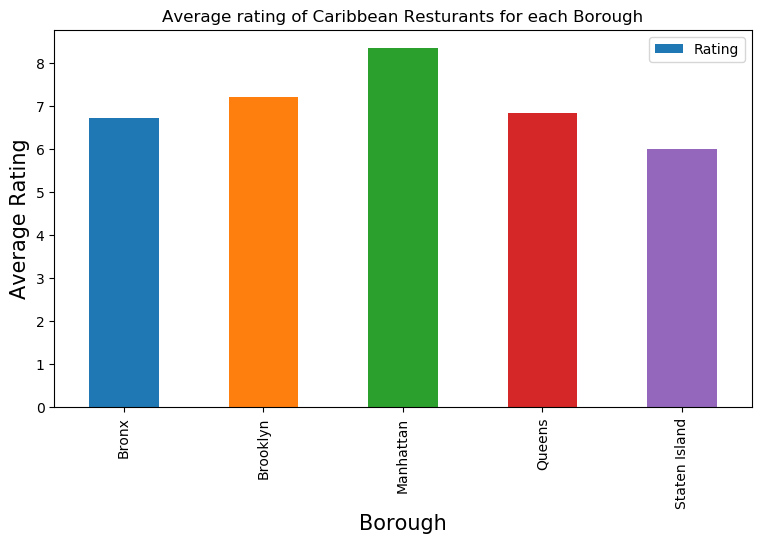

In [38]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Caribbean Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
caribbean_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Get Neighborhoods with average rating of 8.5 and higher

In [41]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.5]

In [42]:
ny_neighborhood_stats

Neighborhood  Average Rating
1             Arverne             8.8
10           Bushwick             8.9
26       East Village             9.2
38  Greenwich Village             9.1
40            Hammels             8.8
47        Kingsbridge             8.5
49        Marble Hill             8.5
51      Midtown South             8.6
56               Noho             9.2
58         North Side             8.9
67   Prospect Heights             9.2
74           Rochdale             8.7
78         Somerville             8.8
94           Woodlawn             8.7

In [43]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [44]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [45]:
ny_neighborhood_stats

Borough       Neighborhood   Latitude  Longitude  Average Rating
0      Queens            Arverne  40.589144 -73.791992             8.8
1    Brooklyn           Bushwick  40.698116 -73.925258             8.9
2   Manhattan       East Village  40.727847 -73.982226             9.2
3   Manhattan  Greenwich Village  40.726933 -73.999914             9.1
4      Queens            Hammels  40.587338 -73.805530             8.8
5       Bronx        Kingsbridge  40.881687 -73.902818             8.5
6   Manhattan        Marble Hill  40.876551 -73.910660             8.5
7   Manhattan      Midtown South  40.748510 -73.988713             8.6
8   Manhattan               Noho  40.723259 -73.988434             9.2
9    Brooklyn         North Side  40.714823 -73.958809             8.9
10   Brooklyn   Prospect Heights  40.676822 -73.964859             9.2
11     Queens           Rochdale  40.675211 -73.772588             8.7
12     Queens         Somerville  40.597711 -73.796648             8.8
13      Bronx           Woodlawn  40.898273 -73.867315             8.7

In [46]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [47]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [48]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [49]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)

In [51]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
ny_geo = r'Borough Boundaries.geojson'

ny_map.choropleth(
    geo_data=ny_geo,
    data=ny_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
ny_map.save('borough_rating.html')

## Conclusion

Prospect Heights(Brooklyn), East Village(Manhattan), Greenwich Village(Manhattan) are some of the best neighborhoods for caribbean cuisine.

Manhattan have potential Caribbean Resturant Market

Staten Island ranks last in average rating of Caribbean Resturants.

Manhattan is the best place to stay if you prefer Caribbean Cuisine.

## Limitations

The ranking is purely on basis of rating of resturants

The accuracy of data depends purely depends on the data provided by FourSquare
